The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs. THe GPDs are reconstructed using the expansion in conformal partial waves and pertinent Mellin-Barnes integrals to resum their expansion in conformal moments.

In [2]:
# Import necessary libraries and set display options
import numpy as np
# import mpmath as mp
# import matplotlib.pyplot as plt
# from scipy.integrate import quad, trapezoid
# from joblib import Parallel, delayed
# from scipy.special import gamma, digamma

# import time
# import re
# import os

# from mstw_pdf import (
#     plot_uv_minus_dv_pdf, 
#     plot_uv_plus_dv_plus_S_pdf,
#     plot_gluon_pdf
# )

# from aac_pdf import(
#     plot_polarized_uv_minus_dv_pdf,
#     plot_polarized_uv_plus_dv_plus_S_pdf,
#     plot_polarized_gluon_pdf
#     )

from stringy_gpds import (
    plot_gpds,plot_gpd_data,
    plot_moments_on_grid,plot_moment,
    evolve_conformal_moment,first_singlet_moment,
    evolve_singlet_D,gluon_helicity,
    quark_helicity, spin_orbit_corelation, total_spin,
    orbital_angular_momentum,
    plot_fourier_transform_singlet_helicity,
    plot_fourier_transform_quark_helicity,
    plot_fourier_transform_quark_spin_orbit_correlation,
    plot_fourier_transform_singlet_spin_orbit_correlation,
    plot_fourier_transform_quark_orbital_angular_momentum,
    plot_fourier_transform_transverse_moments,
    plot_spin_orbit_correlation
)
# Set display options
np.set_printoptions(linewidth=200)

In [1]:
from stringy_gpds import fourier_transform_gluon_helicity
fourier_transform_gluon_helicity(0,2,(0,0))


np.float64(0.11145806843360842)

In [1]:
from stringy_gpds import evolve_conformal_moment, first_singlet_moment
print(evolve_conformal_moment(2,0,-1e-6,1,particle="quark",moment_type="singlet",moment_label="Atilde"))
print(first_singlet_moment(0,1,particle="quark",gpd_label="Htilde"))

0.104014778825582
([0.0], [np.float64(0.10405104684962772)])


In [1]:
from stringy_gpds import R_qq,gamma_qq
print(gamma_qq(0))
print(gamma_qq(1,moment_type="non_singlet_isovector",evolve_type="vector",evolution_order="NLO"))
print(gamma_qq(1,moment_type="singlet",evolve_type="vector",evolution_order="NLO"))


-0.0
19.3621399176955
16.39917695473251


In [1]:
from stringy_gpds import gamma_qg, gamma_gq, gamma_gg,R_qq,R_gq,R_qg,R_gg, gamma_pm,gamma_qq
print(gamma_qq(0,evolution_order="NLO"),gamma_qq(1,moment_type="singlet",evolution_order="NLO"))
print(6 * gamma_qg(1,evolution_order="LO"),6 * gamma_qg(1,evolution_order="NLO"))
print(gamma_gq(1,evolution_order="LO")/6 ,gamma_gq(1,evolution_order="NLO")/6)
print(gamma_gg(1,evolution_order="LO"),gamma_gg(1,evolution_order="NLO"))
# print(R_qq(1,3,moment_type="singlet",evolve_type="vector"),R_qg(1,3,moment_type="singlet",evolve_type="vector"),R_gq(1,3,moment_type="singlet",evolve_type="vector"),R_gg(1,3,moment_type="singlet",evolve_type="vector"))

9.76996261670138e-15 32.46090534979425
-12.0 -11.314814814814815
-0.5925925925925926 -16.460905349794235
1.9999999999999996 11.314814814814909


In [2]:
16.460905349794235*2

32.92181069958847

In [2]:
quark = evolve_conformal_moment(2,0,-1e-4,1,moment_type="singlet",evolution_order="LO")
gluon = evolve_conformal_moment(2,0,-1e-4,1,moment_type="singlet",evolution_order="LO",particle="gluon")
print(quark+gluon)

quark = evolve_conformal_moment(2,0,-1e-4,2,moment_type="singlet",evolution_order="LO")
gluon = evolve_conformal_moment(2,0,-1e-4,2,moment_type="singlet",evolution_order="LO",particle="gluon")
print(quark+gluon)

0.999459569431316
0.999459569431316


In [1]:
from stringy_gpds import evolve_conformal_moment
print(evolve_conformal_moment(1,0,-1e-6,1,evolution_order="NLO"))
print(evolve_conformal_moment(1,0,-1e-6,2,evolution_order="NLO"))

0.9999465024833201
0.9999465024833201


In [1]:
from stringy_gpds import evolve_conformal_moment
quark = evolve_conformal_moment(2,0,0,1,Nf=3,moment_type="singlet",evolution_order="NLO")
gluon = evolve_conformal_moment(2,0,0,1,Nf=3,moment_type="singlet",evolution_order="NLO",particle="gluon")
# print(quark,gluon)
print(quark+gluon)

quark = evolve_conformal_moment(2,0,0,2,Nf=3,moment_type="singlet",evolution_order="NLO")
gluon = evolve_conformal_moment(2,0,0,2,Nf=3,moment_type="singlet",evolution_order="NLO",particle="gluon")
# print(quark,gluon)
print(quark+gluon)

0.999994139203132
1.14976086012251


In [86]:
import numpy as np
def theta(j,k):
    if isinstance(j,(int,float)) and isinstance(k,(int,float)):
        return int(j > k)
    else:
        epsilon = 1e-2
        result = 1 / (1+ np.exp((np.abs(j)-np.abs(k))/epsilon))
        return result

In [ ]:
from stringy_gpds import (
    check_particle_type, PLOT_PATH,IMPACT_PARAMETER_MOMENTS_PATH,
    generate_filename, read_ft_from_csv
)
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import numpy as np

def plot_fourier_transform_transverse_moments_grid(j_max,eta,mu,particle="quark", interpolation=True,n_int=300, vmin = 0 , vmax = 1 ):
    """
    Generates a density plot of the 2D Fourier transfrom of RGE-evolved 
    conformal moments for a given moment type and a transversely polarzied target.
    Automatically uses A and B moments. Code requires all tables to have same b_max
    and be available on the file system. To generate the data use the function
    plot_fourier_transform_transverse_moments.
    
    Parameters:
    - j_max (float): Maximal Conformal spin
    - eta (float): Skewness parameter
    - mu (float): RGE scale
    - particle (str. optional): "quark" or "gluon". Default is quark.
    - moment_label (str. optiona): Label of conformal moment, e.g. A
    - interpolation (bool, optional): Interpolate data points on finer grid
    - n_int (int, optional): Number of points used for interpolation
    - vmin (float ,optioanl): Sets minimum value of colorbar
    - vmax (float, optional): Sets maximum value of colorbar
    """
    def get_subplot_positions_and_heights(n_rows,n_cols):
        """
        Returns the positions and heights of each subplot in the grid.
        
        Returns:
        - A list of row heights and positions for each subplot.
        """
        row_positions_and_heights = []
        
        # Step 1: Create a hidden figure to determine subplot heights without labels/ticks
        fig_hidden, axs_hidden = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows*4))
        fig_hidden.subplots_adjust(wspace=0, hspace=0)  # Remove extra spacing
        
        for row in range(n_rows):
            # Get the bounding box (position and height) of the last column in each row
            bbox = axs_hidden[row,-1].get_position()
            row_positions_and_heights.append((bbox.x0, bbox.y0, bbox.width, bbox.height))  # Position (x0, y0), width, and height
        
        plt.close(fig_hidden)  # Close the hidden figure
        
        return row_positions_and_heights

            
    check_particle_type(particle)

    if len(vmin)<j_max or len(vmax)<j_max:
        raise ValueError("Supply vmin and vmax as arrays of length j_max")

    FILE_PATH = PLOT_PATH + "imp_param_transv_pol_moments.pdf"

    moment_types = ["non_singlet_isovector", "non_singlet_isoscalar", "u", "d"]

    # Initialize cache to store Fourier transforms for "non_singlet_isovector" and "non_singlet_isoscalar"
    #cache = {}
    cache = {j: {mom_type: None for mom_type in moment_types} for j in range(1, j_max + 1)}

    # Determine figure layout
    fig, axs = plt.subplots(j_max, len(moment_types), figsize=(len(moment_types) * 4, j_max*4))
    row_positions_and_heights = get_subplot_positions_and_heights(j_max,len(moment_types))

    title_map = {
        "non_singlet_isovector": "u-d",
        "non_singlet_isoscalar": "u+d",
        "u": "u",
        "d": "d"
    }
    hbarc = 0.1975

    for j in range(1, j_max + 1):
        for i, mom_type in enumerate(moment_types):
            READ_WRITE_PATH = IMPACT_PARAMETER_MOMENTS_PATH + "imp_param_transv_pol_moment_j_" + str(j) + "_"  + mom_type 
            row, col = j-1, i
            ax = axs[row, col]

            title = title_map[mom_type]

            # Compute Fourier transform and cache the results for non_singlet_isovector and non_singlet_isoscalar
            if mom_type in ["non_singlet_isovector", "non_singlet_isoscalar"]:
                if cache[j][mom_type] is None:
                    file_name = generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
                    b_x_fm, b_y_fm, fourier_transform_moment_values_flat = read_ft_from_csv(file_name)
                    b_max = max(b_x_fm)/hbarc
                    n_b = len(fourier_transform_moment_values_flat)
                    b_x = np.linspace(-b_max, b_max, n_b)
                    b_y = np.linspace(-b_max, b_max, n_b)
                    cache[j][mom_type] = fourier_transform_moment_values_flat

            if mom_type in ["u","d"]:
                file_name = generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
                b_x_fm, b_y_fm, _ = read_ft_from_csv(file_name)

                if mom_type == "u":
                    prf = 1
                if mom_type == "d":
                    prf = -1 
                fourier_transform_moment_values_flat = (cache[j]["non_singlet_isoscalar"] + prf * cache[j]["non_singlet_isovector"]) / 2

            if interpolation:
                ft_interpolation = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat)

                # Call the interpolation on a finer grid
                b_x = np.linspace(-b_max, b_max, n_int)
                b_y = np.linspace(-b_max, b_max, n_int)
                b_x_fm = b_x * hbarc
                b_y_fm = b_y * hbarc

                fourier_transform_moment_values_flat = ft_interpolation(b_x_fm, b_y_fm)

            # Generate 2D density plot
            im = ax.pcolormesh(b_x_fm, b_y_fm, fourier_transform_moment_values_flat, 
                                shading='auto', cmap='jet',vmin=vmin[j-1], vmax=vmax[j-1],rasterized=True)
            ax.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            if i == 0:
                ax.set_ylabel(r'$b_y\,[\mathrm{fm}]$', fontsize=14)
            if j == 1:
                ax.set_title(rf"$\rho_{{n,\perp}}^{{{title}}}$", fontsize=14)

            ax.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax.set_ylim([-b_max * hbarc, b_max * hbarc])
            
            if col == len(moment_types)-1:
                # print(ax.get_position().x1, ax.get_position().y0,ax.get_position().height)
                # Get positions without labels
                x0, y0, width, height = row_positions_and_heights[row]
                # We shift the x position by the width of the plot
                # such that it attaches to the right
                x0 += width
                cbar_ax = fig.add_axes([x0, y0, 0.01, height])
                fig.colorbar(im, cax=cbar_ax)
            if col == 0:
                ax.text(
                    0.05, 0.95,  
                    rf"$n={j}$",  
                    transform=ax.transAxes, 
                    ha='left', va='top', 
                    fontsize=14, color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')  # Adds a semi-transparent background
                )

            # Remove ticks and labels
            if i != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
                ax.set_ylabel(None)
            if j != j_max:
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel(None)

    plt.subplots_adjust(wspace=0, hspace=0)


    # File export
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight",dpi=600)

    # Adjust layout and show the plot
    plt.show()
    plt.close()

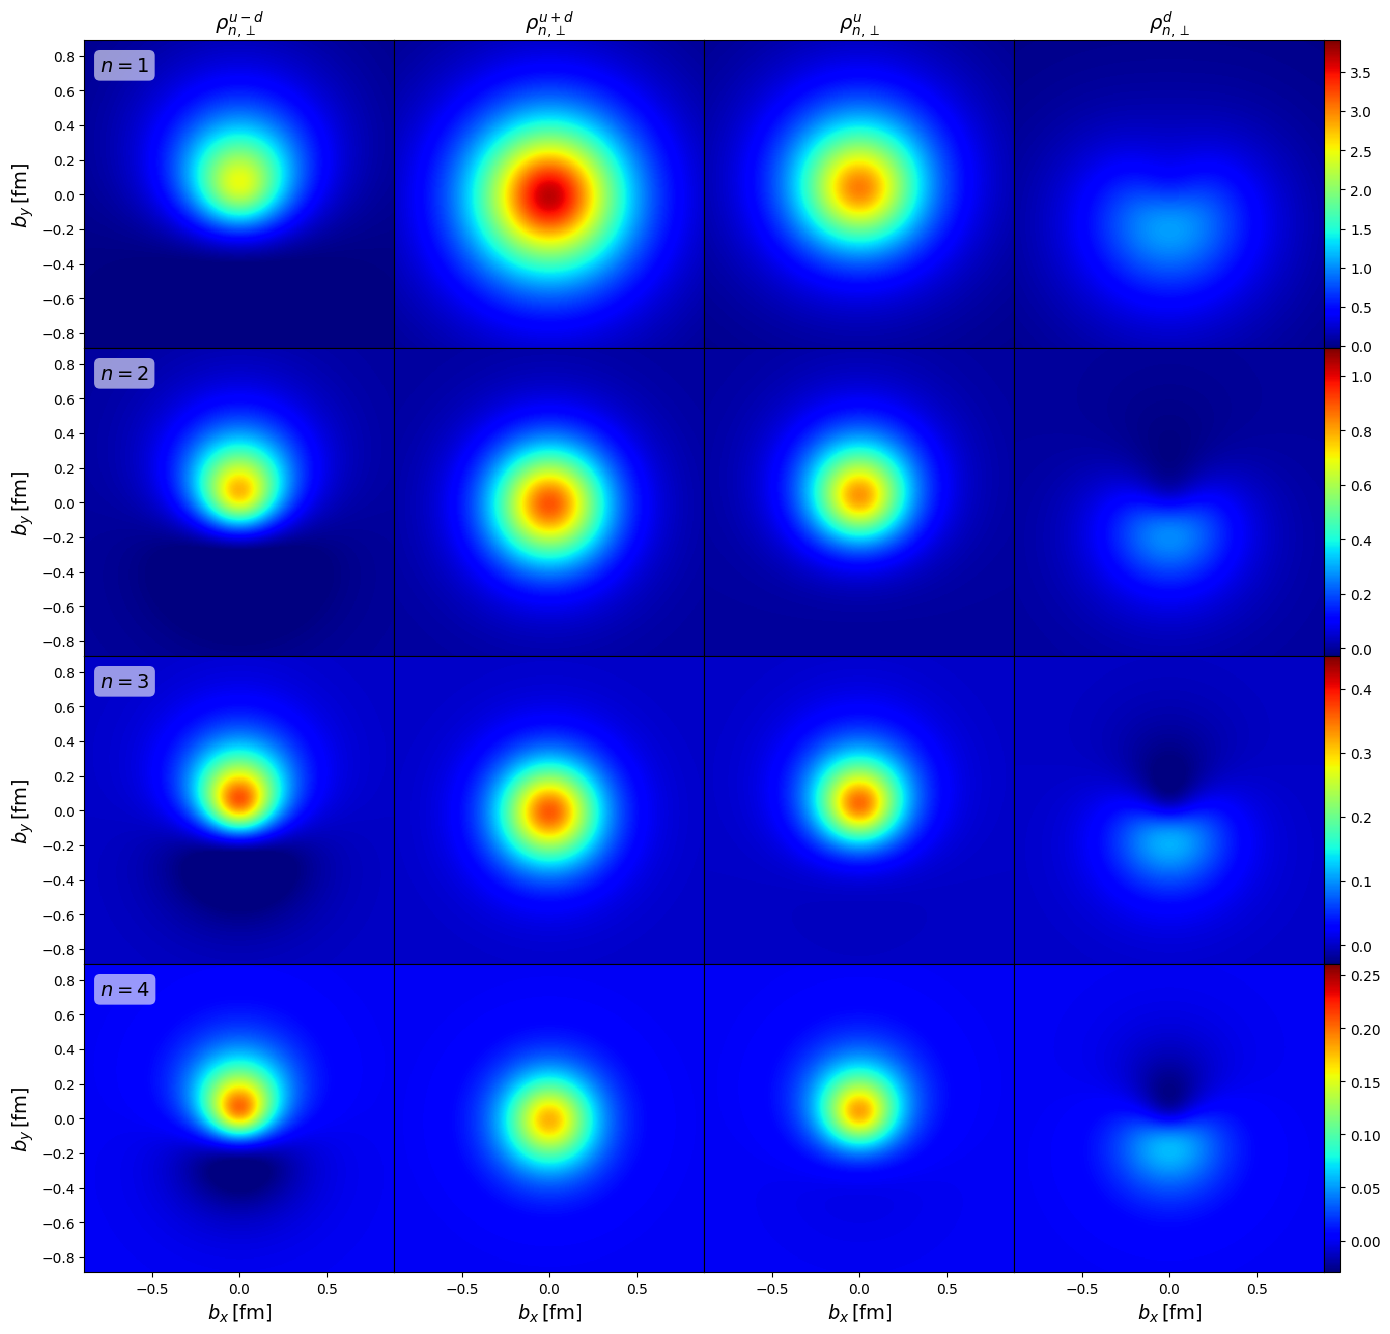

In [ ]:
plot_fourier_transform_transverse_moments_grid(4,0,2,interpolation=True,vmin=[-0.03,-.03,-0.03,-0.03],vmax=[3.9,1.1,.45,.26])

In [3]:
j_u_minus_d, j_u_minus_d_plus, j_u_minus_d_minus =  total_spin(0,2,particle="quark",moment_type="non_singlet_isovector")
j_u_plus_d, j_u_plus_d_plus, j_u_plus_d_minus =  total_spin(0,2,particle="quark",moment_type="non_singlet_isoscalar")
j_u = (j_u_minus_d + j_u_plus_d)/2
j_d = (j_u_plus_d - j_u_minus_d)/2
j_u_plus = np.sqrt(j_u_minus_d_plus**2+j_u_plus_d_plus**2)/2
j_u_minus = np.sqrt(j_u_minus_d_minus**2+j_u_plus_d_minus**2)/2
# print(l_u_minus_d_plus,l_u_minus_d_minus)
# print(l_u_plus_d_plus,l_u_plus_d_minus)
print(j_u_plus_d,j_u_plus_d_plus,j_u_plus_d_minus)
print(j_u_minus_d,j_u_minus_d_plus,j_u_minus_d_minus)
print(j_u,j_d)
print(j_u_plus,j_u_minus)
# print(l_u+l_d+l_s)

0.17089890717084838 0.02185827594749296 0.020865769369075665
0.4208675673440858 0.08602358143137934 0.08211755651547331
0.2958832372574671 -0.12498433008661872
0.04437860066991156 0.042363526232584235


Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.011715 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.012970 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.009802 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/singlet_quark_GPD_Htilde.pdf


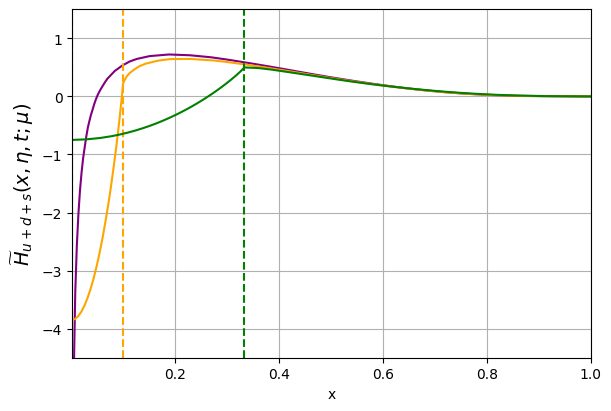

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="singlet",gpd_label="Htilde",error_bars=False, read_from_file= True,write_to_file=False, y_0= -4.5, y_1 =1.5)

Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.027395 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.023764 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.020663 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/non_singlet_isovector_quark_GPD_E.pdf


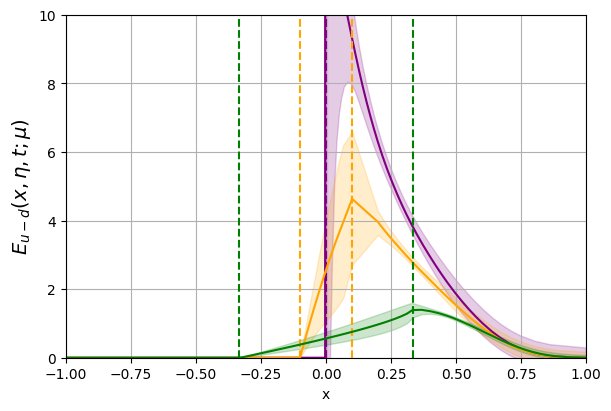

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,gpd_type="non_singlet_isovector",gpd_label="E",error_bars=True, read_from_file= True,write_to_file=False, y_0= 0, y_1 =10)

Plots of conformal moments $\mathbb{G}(n,\eta,tb_\perp)$ in momentum space

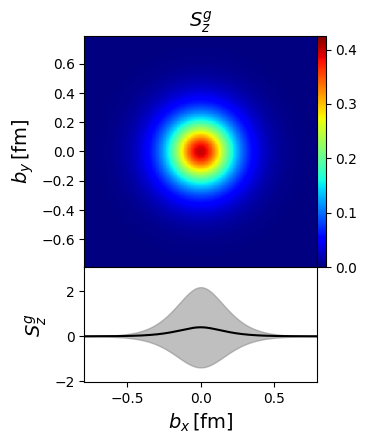

In [5]:
plot_fourier_transform_singlet_helicity(0,2,particle="gluon",read_from_file=True,write_to_file=False,b_max=4, n_b = 50, vmin=0,vmax=.425)

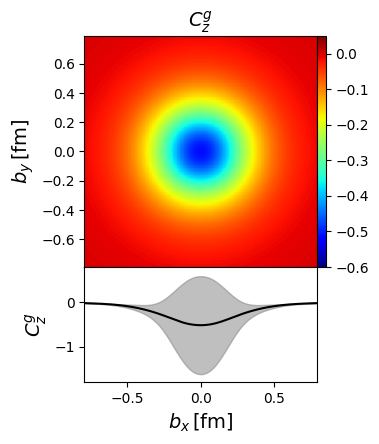

In [6]:
plot_fourier_transform_singlet_spin_orbit_correlation(0,2,particle="gluon",read_from_file=True,write_to_file=False,b_max=4, n_b = 50,Delta_max=8,vmin = -.6, vmax = 0.05 ,ymin=-1.8, ymax = .8)

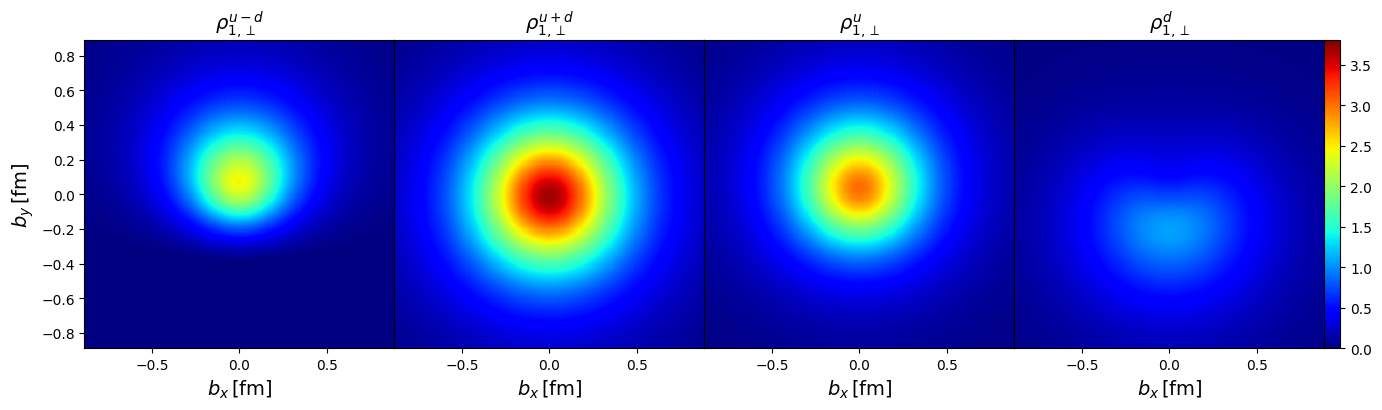

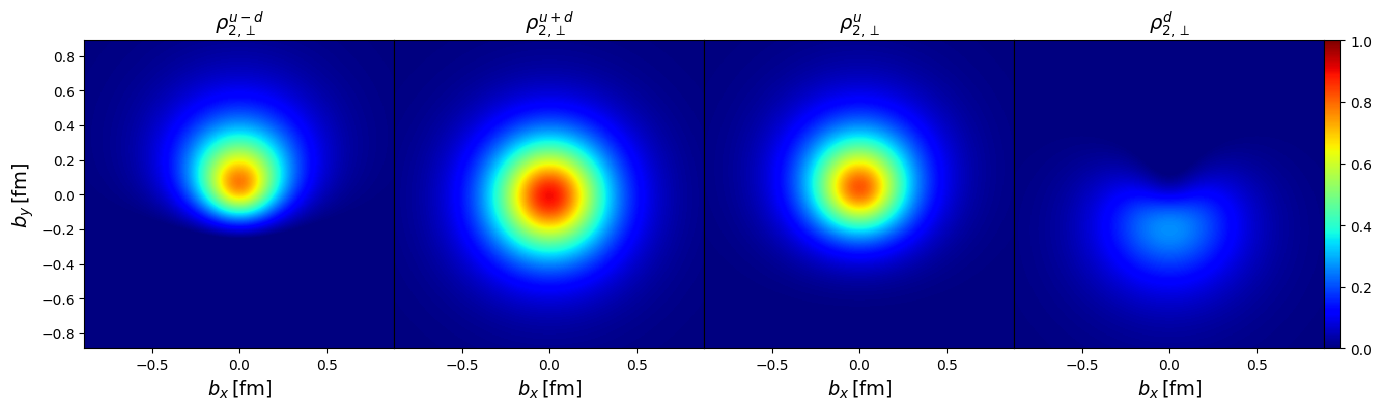

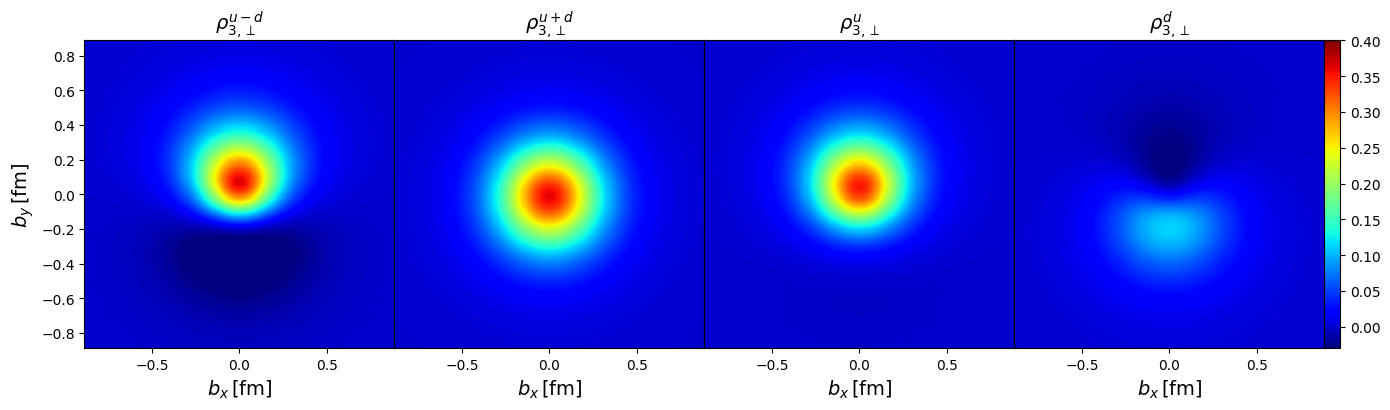

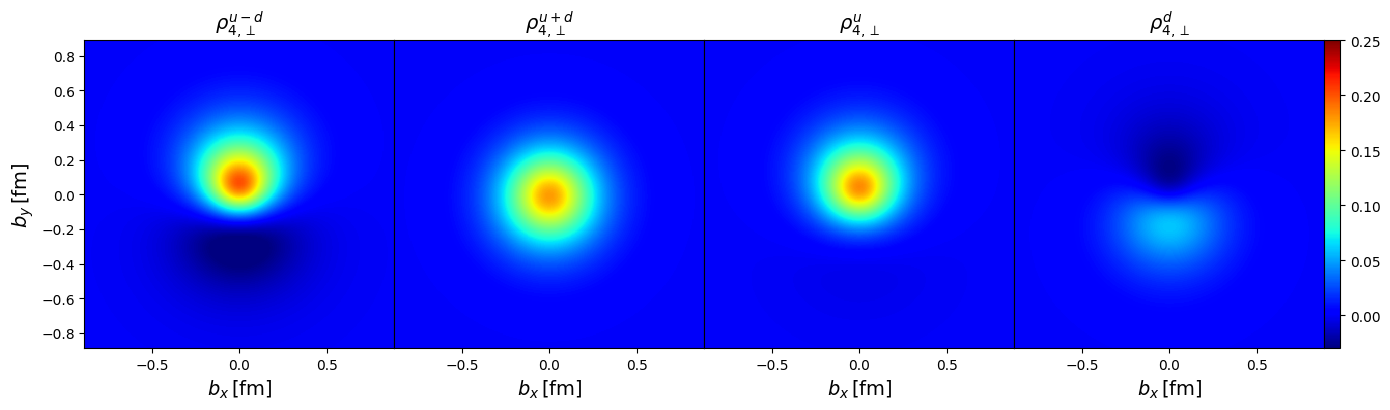

In [3]:
plot_fourier_transform_transverse_moments(1,0,2,moment_type="all",read_from_file=True,write_to_file=False,interpolation=True,vmin=0, vmax=3.8)
plot_fourier_transform_transverse_moments(2,0,2,moment_type="all",read_from_file=True,write_to_file=False,interpolation=True,vmin=0, vmax=1)
plot_fourier_transform_transverse_moments(3,0,2,moment_type="all",read_from_file=True,write_to_file=False,interpolation=True,vmin=-.03, vmax=.4)
plot_fourier_transform_transverse_moments(4,0,2,moment_type="all",read_from_file=True,write_to_file=False,interpolation=True,vmin=-.03, vmax=.25)

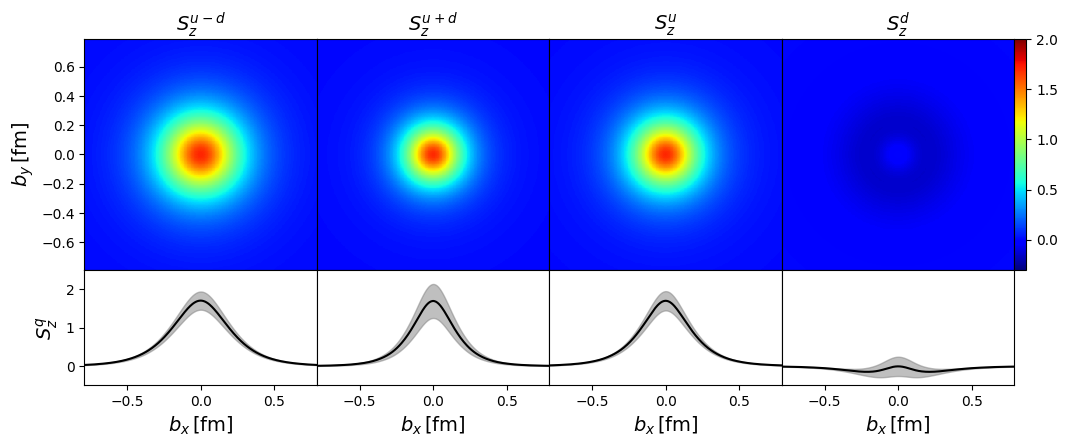

In [2]:
plot_fourier_transform_quark_helicity(0,2,read_from_file=True,write_to_file=False,b_max=4, n_b = 100,moment_type="all",vmin = -0.3, vmax = 2)

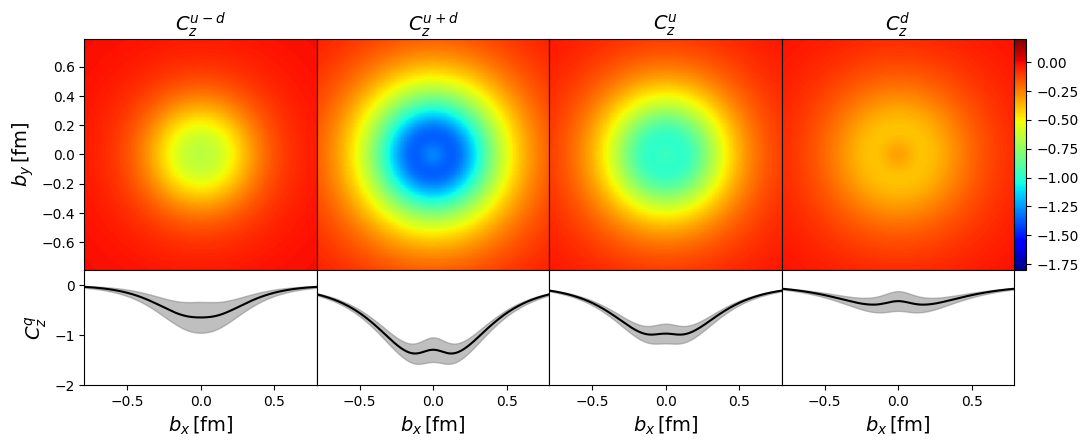

In [3]:
plot_fourier_transform_quark_spin_orbit_correlation(0,2,read_from_file=True,write_to_file=False,b_max=4, n_b = 100,moment_type="all",Delta_max=8,vmin = -1.8, vmax = .2,ymin=-2, ymax = .3)

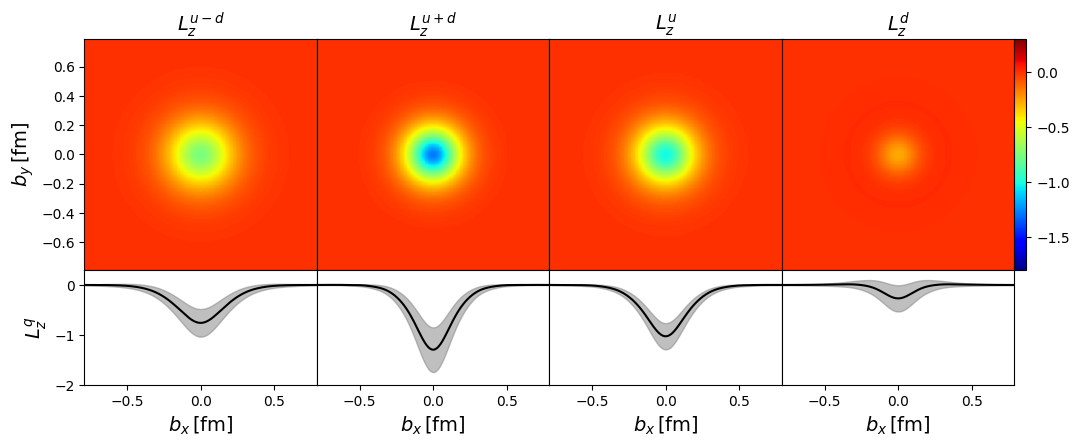

In [4]:
plot_fourier_transform_quark_orbital_angular_momentum(0,2,read_from_file=True,write_to_file=False,b_max=4, n_b = 100,moment_type="all",Delta_max=7,vmin = -1.8, vmax = .3,ymin=-2)

In [6]:
l_u_minus_d, l_u_minus_d_plus ,l_u_minus_d_minus = orbital_angular_momentum(0,2)
l_u_plus_d, l_u_plus_d_plus ,l_u_plus_d_minus = orbital_angular_momentum(0,2,moment_type="non_singlet_isoscalar")
l_s, _ ,_ = orbital_angular_momentum(0,2,moment_type="singlet")
l_u = (l_u_minus_d + l_u_plus_d)/2
l_d = (l_u_plus_d - l_u_minus_d)/2
l_u_plus = np.sqrt(l_u_minus_d_plus**2+l_u_plus_d_plus**2)/2
l_u_minus = np.sqrt(l_u_minus_d_minus**2+l_u_plus_d_minus**2)/2
# print(l_u_minus_d_plus,l_u_minus_d_minus)
# print(l_u_plus_d_plus,l_u_plus_d_minus)
print(l_u_plus_d,l_u_plus_d_plus,l_u_plus_d_minus)
print(l_u_minus_d,l_u_minus_d_plus,l_u_minus_d_minus)
print(l_u,l_d,l_s)
print(l_u_plus,l_u_minus)
# print(l_u+l_d+l_s)

-0.03515109816975892 0.06029649825648719 0.05994383876564187
-0.219103215838246 0.1182642498189208 0.11545418706579208
-0.12712715700400246 0.09197605883424353 0.0152597925474197
0.06637412991374476 0.06504408719665489


In [4]:
s_u_minus_d, s_u_minus_d_plus, s_u_minus_d_minus = quark_helicity(0,2,moment_type="non_singlet_isovector")
s_u_plus_d, s_u_plus_d_plus, s_u_plus_d_minus = quark_helicity(0,2,moment_type="non_singlet_isoscalar")
s_s, s_s_plus, s_s_minus= quark_helicity(0,2,moment_type="singlet")
s_g, s_g_plus, s_g_minus = gluon_helicity(0,2)
s_u = (s_u_plus_d+s_u_minus_d)/2
s_u_plus = np.sqrt(s_u_minus_d_plus**2+s_u_plus_d_plus**2)/2
s_u_minus = np.sqrt(s_u_minus_d_minus**2+s_u_plus_d_minus**2)/2
s_d = (s_u_plus_d-s_u_minus_d)/2
print(s_u_minus_d,s_u_minus_d_minus,s_u_minus_d_plus)
print(s_u_plus_d,s_u_plus_d_plus,s_u_plus_d_minus)
print(s_u,s_u_plus,s_u_minus)
print(s_d,s_u_plus,s_u_minus)
# print(s_s,s_s_plus,s_s_minus)
# print(s_g,s_g_plus,s_g_minus)
# print(s_u+s_d+s_s)
# print(s_g)

0.6399707831823318 0.08115649217992948 0.08115649217992948
0.2060500053406073 0.05619504848825929 0.05619504848825929
0.4230103942614696 0.049356508429863555 0.049356508429863555
-0.21696038892086225 0.049356508429863555 0.049356508429863555


In [5]:
c_u_minus_d, c_u_minus_d_plus, c_u_minus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isovector")
c_u_plus_d, c_u_plus_d_plus, c_u_plus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isoscalar")
c_u = (c_u_plus_d+c_u_minus_d)/2
c_u_plus = np.sqrt(c_u_minus_d_plus**2+c_u_plus_d_plus**2)/2
c_u_minus = np.sqrt(c_u_minus_d_minus**2+c_u_plus_d_minus**2)/2
c_d = (c_u_plus_d-c_u_minus_d)/2
print(c_u_minus_d,c_u_minus_d_minus,c_u_minus_d_plus)
print(c_u_plus_d,c_u_plus_d_plus,c_u_plus_d_minus)
print(c_u,c_u_plus,c_u_minus)
print(c_d,c_u_plus,c_u_minus)

-0.39844253802641905 0.17950598244725235 0.17043054856399925
-1.4625505084866472 0.17010833004615744 0.1792000831518223
-0.9304965232565332 0.12039872905778339 0.12682179183402717
-0.532053985230114 0.12039872905778339 0.12682179183402717


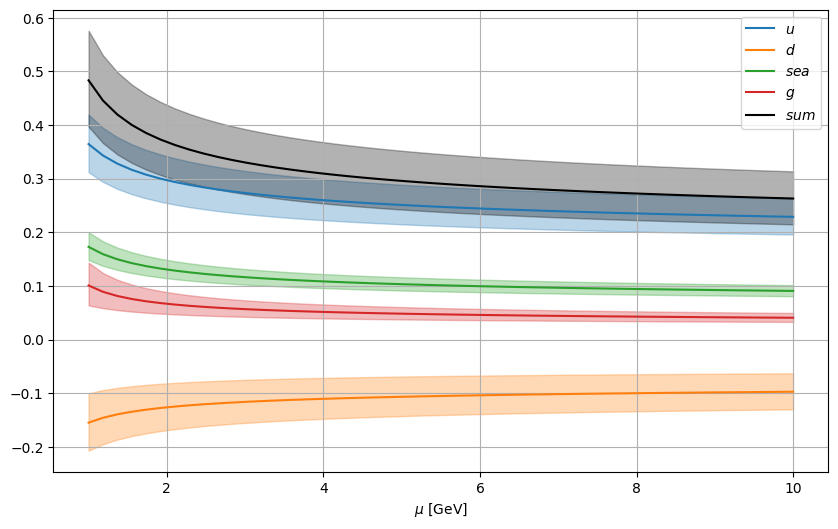

In [5]:
import matplotlib.pyplot as plt

def plot_quark_gluon_spin():
    def mpf_tuple_to_float(tup):
        """Convert a tuple of mpf arrays/lists to numpy float64 arrays."""
        return tuple(np.array([float(x) for x in arr], dtype=np.float64) for arr in tup)

    def quark_gluon_spin_float(*args, **kwargs):
        """Wrapper around quark_gluon_spin that converts all outputs to np.float64 arrays."""
        return mpf_tuple_to_float(quark_gluon_spin(*args, **kwargs))
    mu = np.linspace(1, 10, 50)

    # Retrieve data and errors, converted to float arrays immediately
    j_u_minus_d, j_u_minus_d_plus, j_u_minus_d_minus = quark_gluon_spin_float(0, mu)
    j_u_plus_d, j_u_plus_d_plus, j_u_plus_d_minus = quark_gluon_spin_float(0, mu, moment_type="non_singlet_isoscalar")
    j_s, j_s_plus, j_s_minus = quark_gluon_spin_float(0, mu, moment_type="singlet")
    j_g, j_g_plus, j_g_minus = quark_gluon_spin_float(0, mu, particle="gluon", moment_type="singlet")

    # Compute individual quark spins
    j_u = (j_u_minus_d + j_u_plus_d) / 2
    j_d = (j_u_plus_d - j_u_minus_d) / 2

    # Compute errors
    j_u_plus = np.sqrt(j_u_minus_d_plus**2 + j_u_plus_d_plus**2) / 2
    j_u_minus = np.sqrt(j_u_minus_d_minus**2 + j_u_plus_d_minus**2) / 2

    j_total = j_u + j_d + j_s + j_g
    error_plus = np.sqrt(2 * j_u_plus**2 + j_s_plus**2 + j_g_plus**2)
    error_minus = np.sqrt(2 * j_u_minus**2 + j_s_minus**2 + j_g_minus**2)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Helper function for plotting with error bands
    def plot_with_errorband(mu, value, err_plus, err_minus, label, color):
        plt.plot(mu, value, label=label, color=color)
        plt.fill_between(mu, value - err_minus, value + err_plus, color=color, alpha=0.3)

    plot_with_errorband(mu, j_u, j_u_plus, j_u_minus, r'$u$', 'tab:blue')
    plot_with_errorband(mu, j_d, j_u_plus, j_u_minus, r'$d$', 'tab:orange')
    plot_with_errorband(mu, j_s, j_s_plus, j_s_minus, r'$sea$', 'tab:green')
    plot_with_errorband(mu, j_g, j_g_plus, j_g_minus, r'$g$', 'tab:red')
    plot_with_errorband(mu, j_total, error_plus, error_minus, r'$sum$', 'k')

    plt.xlabel(r'$\mu$ [GeV]')
    #plt.ylabel(r'Angular Momentum Contribution')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_quark_gluon_spin()


In [ ]:
def total_spin(t,mu):
    j_u_minus_d, j_u_minus_d_plus ,j_u_minus_d_minus= quark_gluon_spin(t,mu)
    j_u_plus_d, j_u_plus_d_plus , j_u_plus_d_minus = quark_gluon_spin(t,mu,moment_type="non_singlet_isoscalar")
    j_s, j_s_plus, j_s_minus = quark_gluon_spin(t,mu,moment_type="singlet")
    j_g, j_g_plus ,j_g_minus = quark_gluon_spin(t,mu,particle="gluon",moment_type="singlet")

    j_u = (j_u_minus_d+j_u_plus_d)/2
    j_d = (j_u_plus_d-j_u_minus_d)/2
    j_u_plus = np.sqrt((j_u_minus_d_plus)**2+(j_u_plus_d_plus)**2)/2
    j_u_minus = np.sqrt((j_u_minus_d_minus)**2+(j_u_plus_d_minus)**2)/2
    error_plus = np.sqrt(2*j_u_plus**2+j_s_plus**2+j_g_plus**2)
    error_minus= np.sqrt(2*j_u_minus**2+j_s_minus**2+j_g_minus**2)
    print(j_u + j_d + j_s + j_g, f'({error_plus})({error_minus})')

0.368205268227426 (0.0691794005656669)(0.0679402889812622)


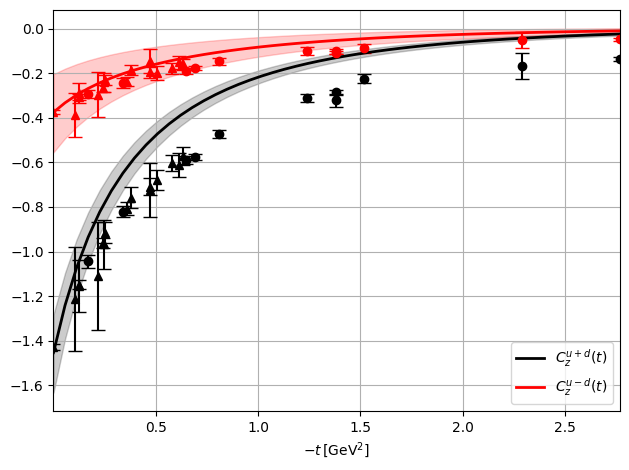

In [2]:
plot_spin_orbit_correlation()

Plots of conformal moments $\mathbb{G}(n,\eta,t)$ in momentum space

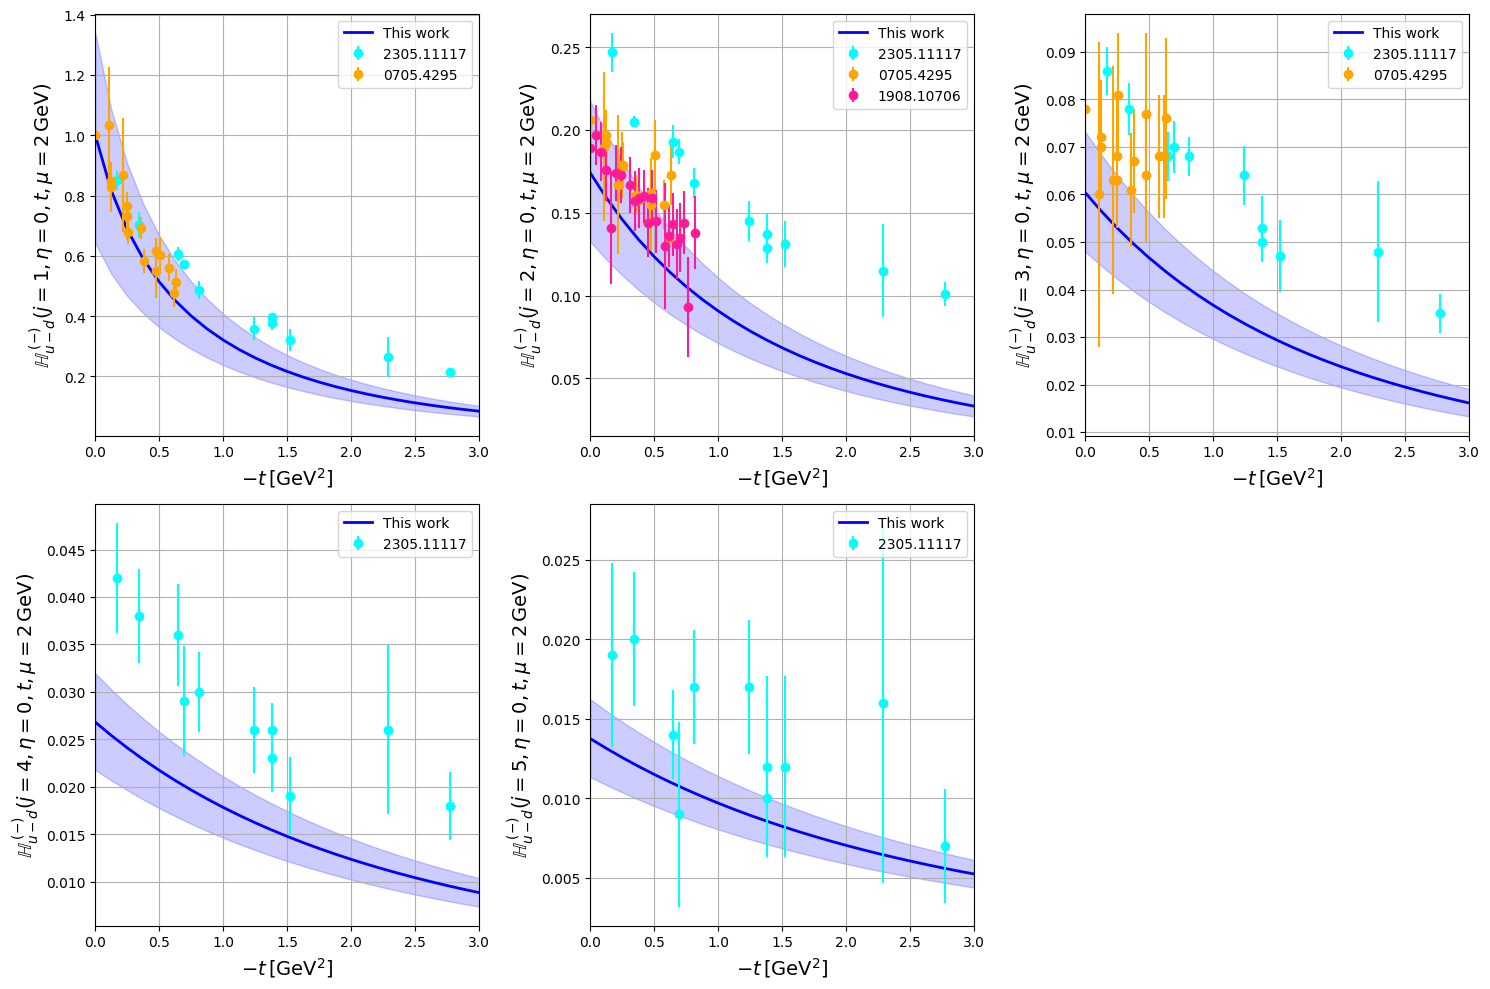

In [2]:
#non_singlet_isovector
y_label = "$\\mathbb{{H}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

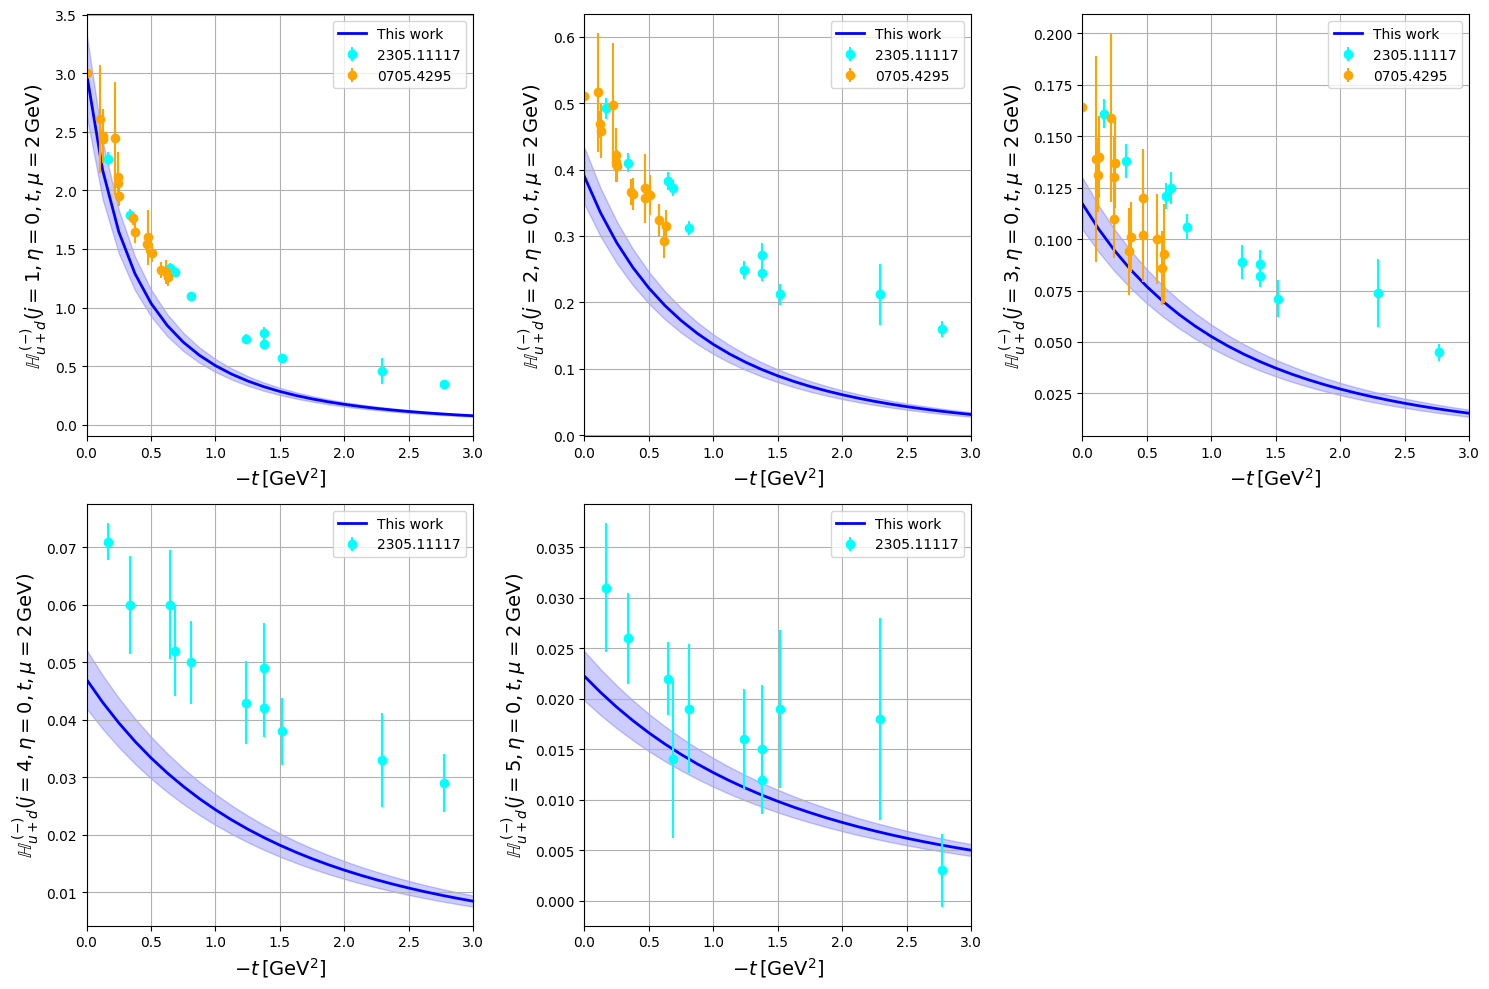

In [3]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{H}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

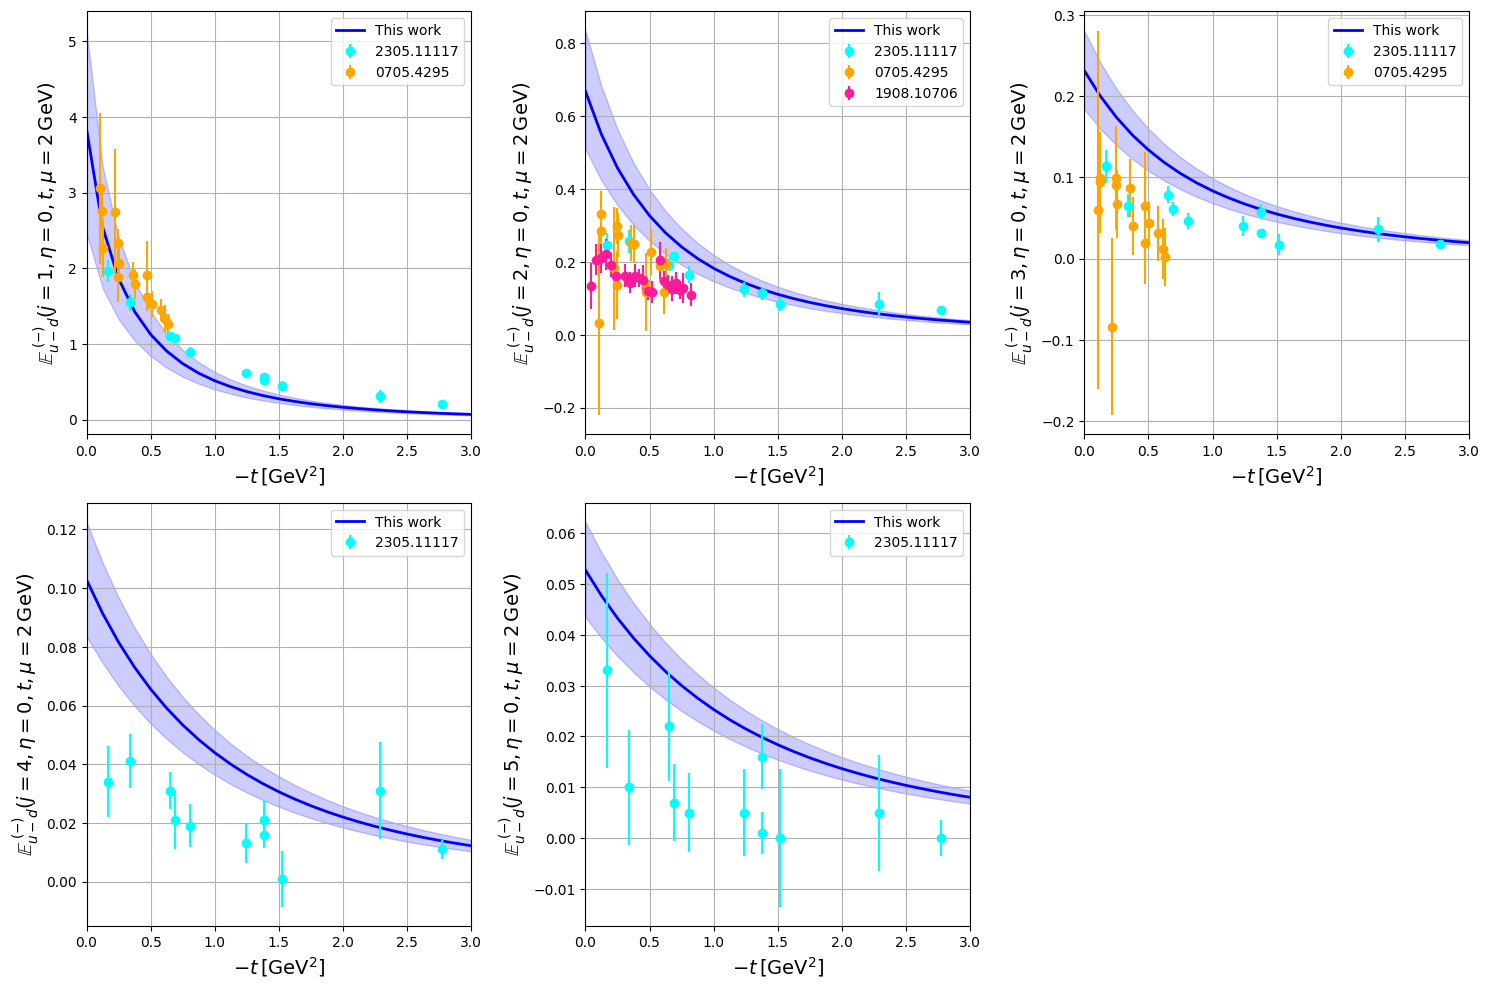

In [4]:
#non_singlet_isovector
y_label = "$\\mathbb{{E}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

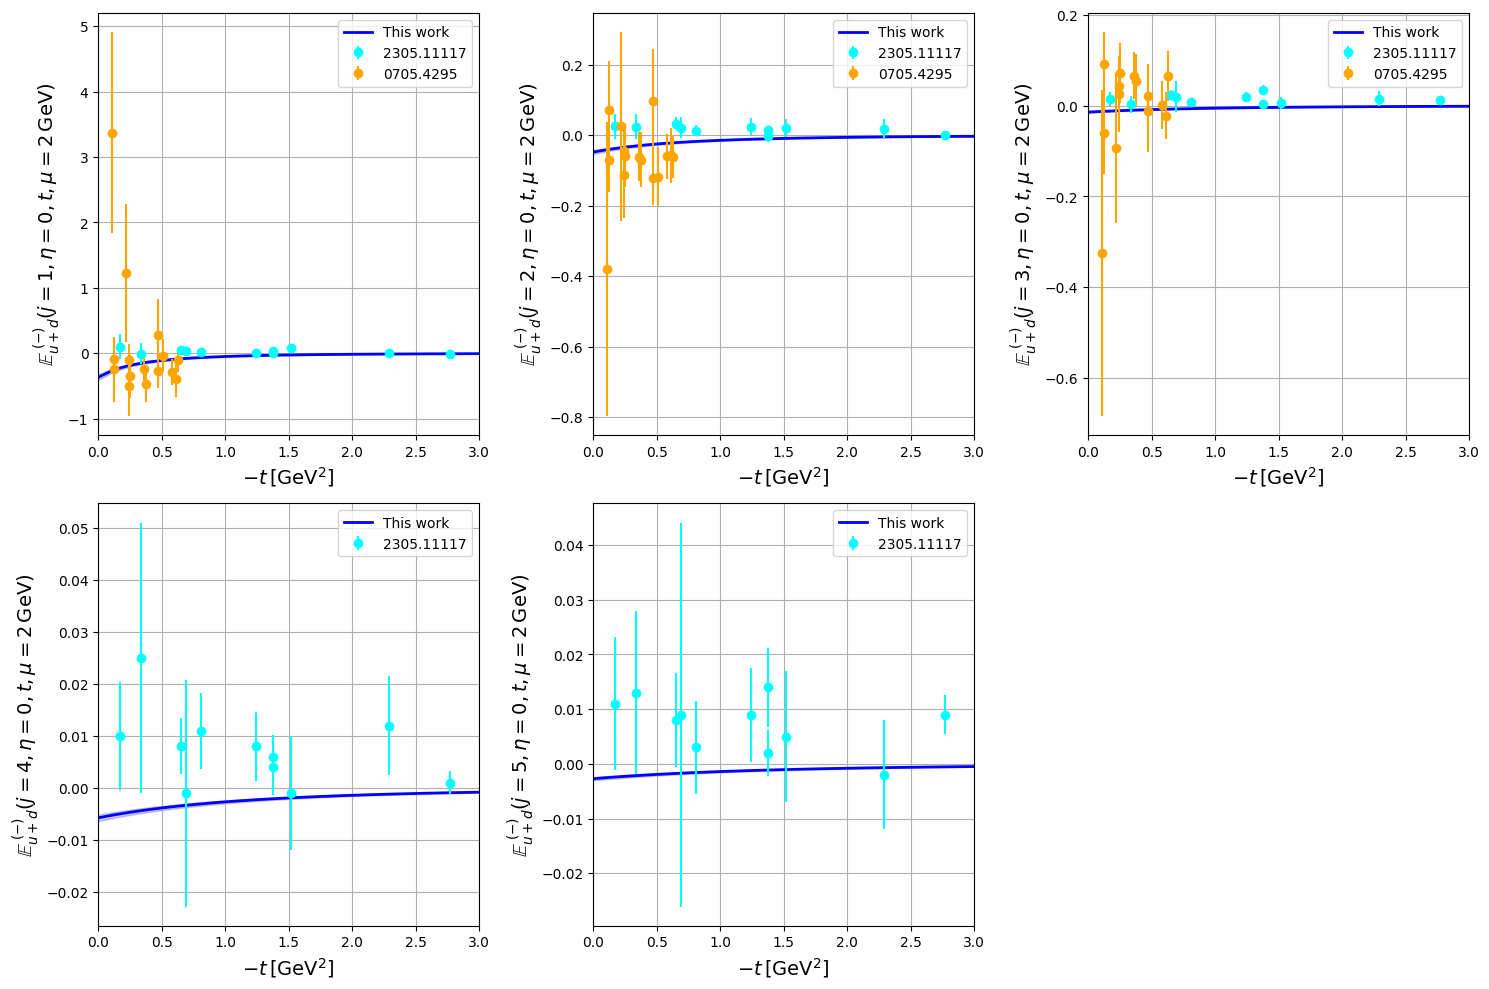

In [6]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{E}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

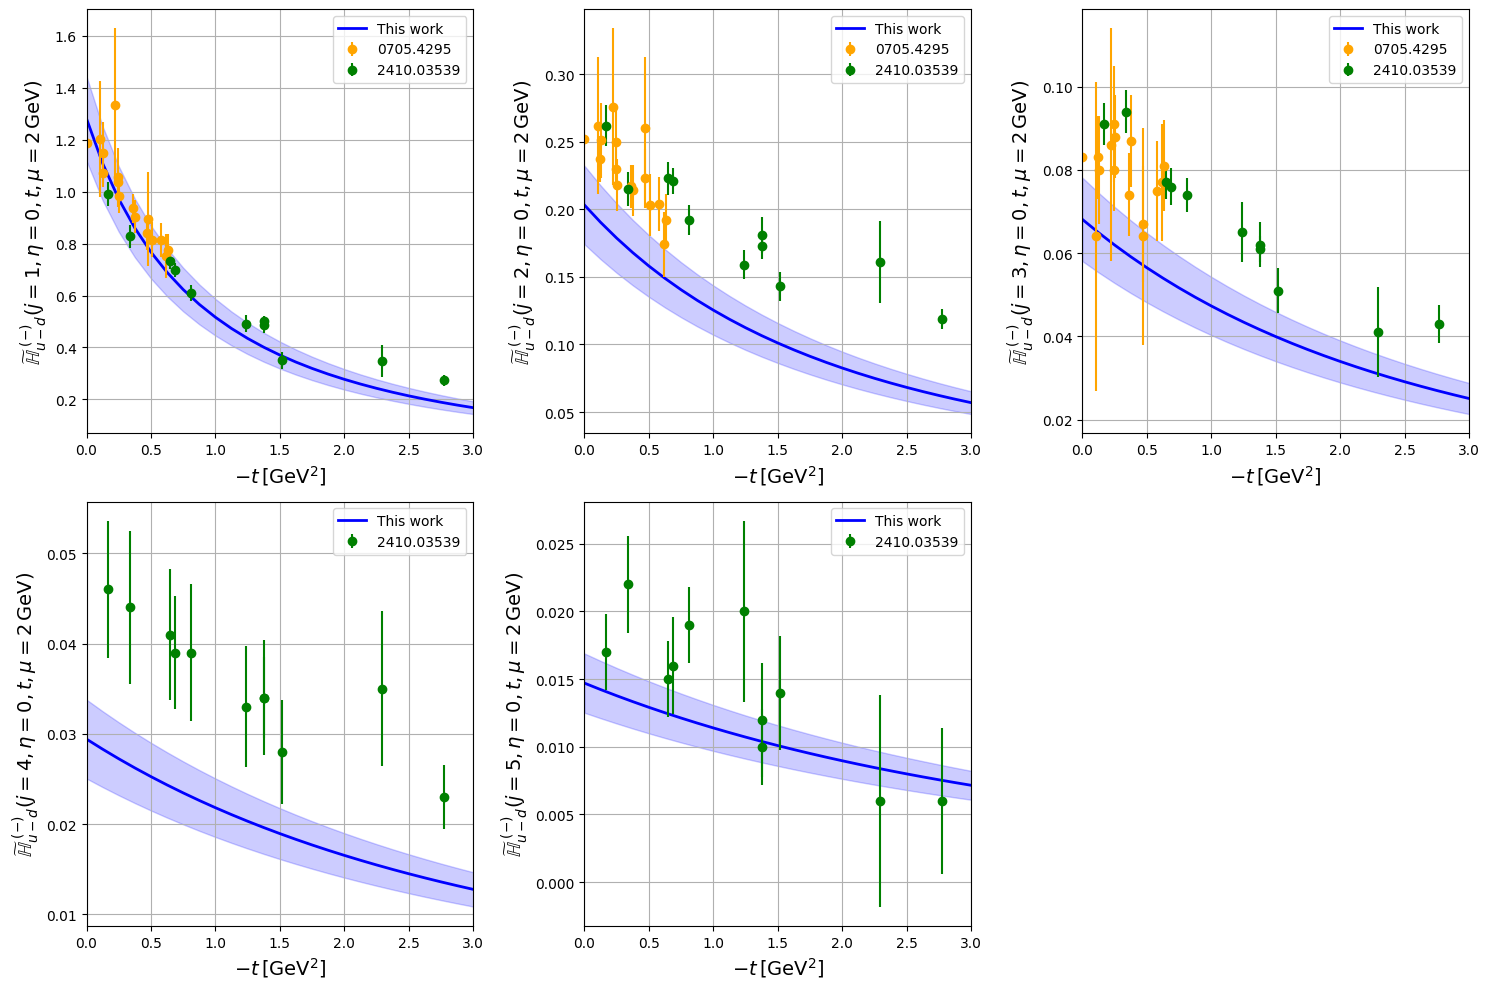

In [7]:
#non_singlet_isovector Axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

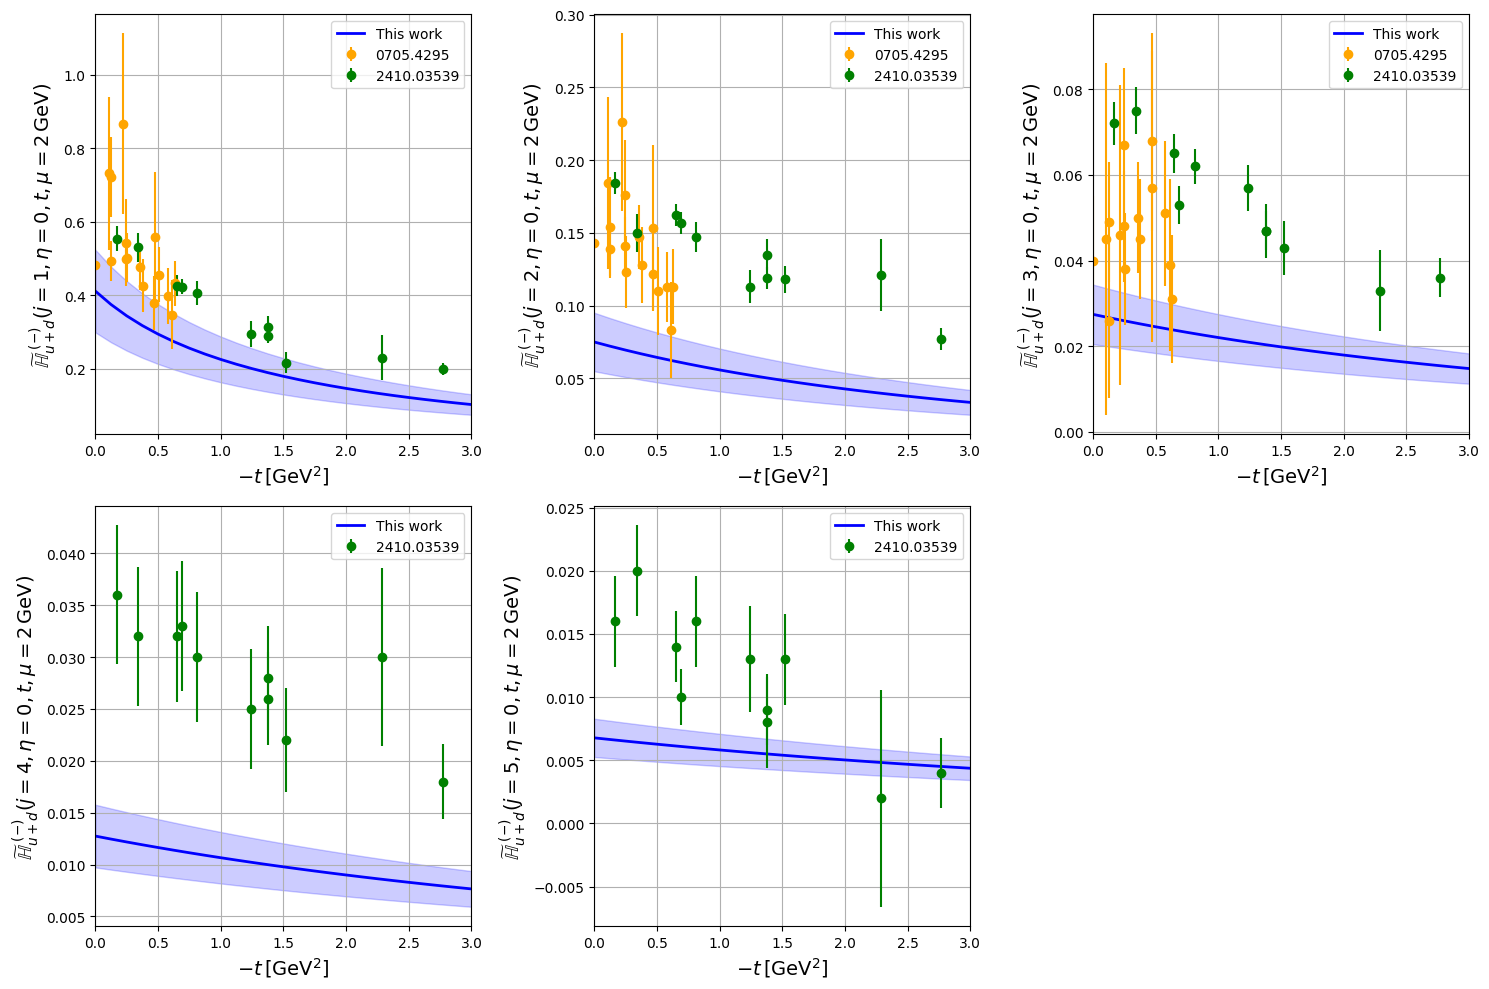

In [8]:
#non_singlet_isoscalar Axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

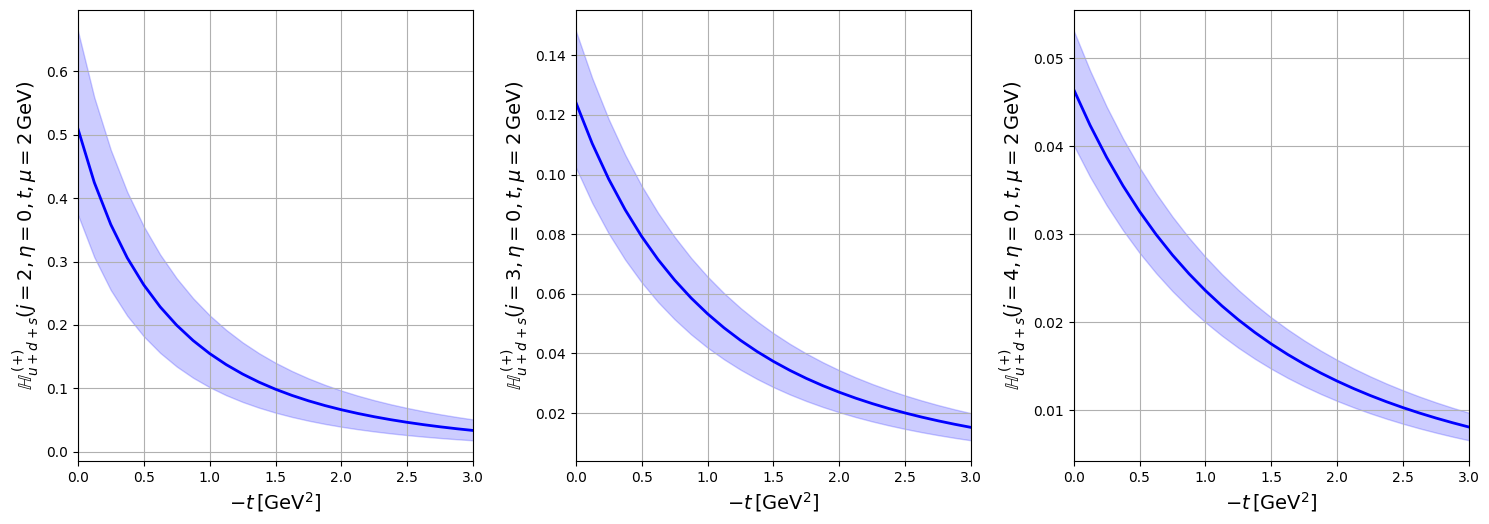

In [2]:
# Sea Quark singlet
y_label = "$\\mathbb{{H}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

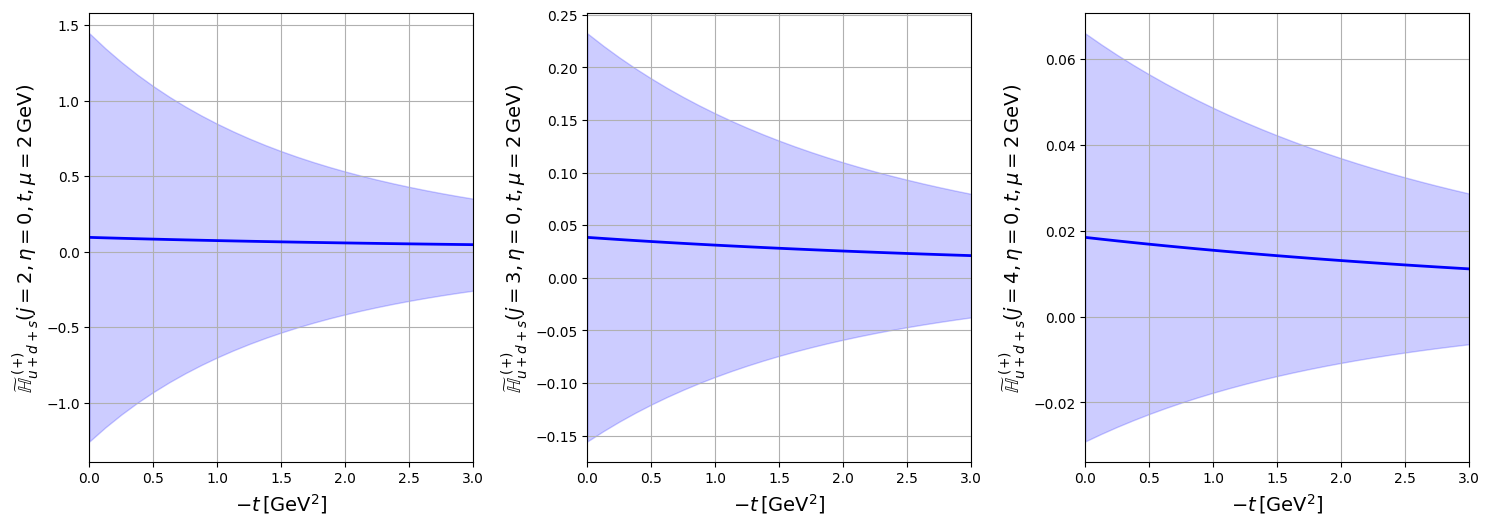

In [3]:
# Sea Quark singlet
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"quark",moment_type, moment_label,"LO",25)

In [8]:
# 0.510024649589122
# -1.30044714988575
# 0.50111263175031
# -2.57000756593034
print(evolve_conformal_moment(2,0,-1e-4,2,3,"quark","singlet","A",error_type="central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"quark","A",error_type="central"))
print(evolve_conformal_moment(2,0,-1e-4,2,3,"gluon","singlet","A",error_type="central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"gluon","A",error_type="central"))

0.510002965425288
-1.29999956564934
0.501008173861975
-2.56999962157614


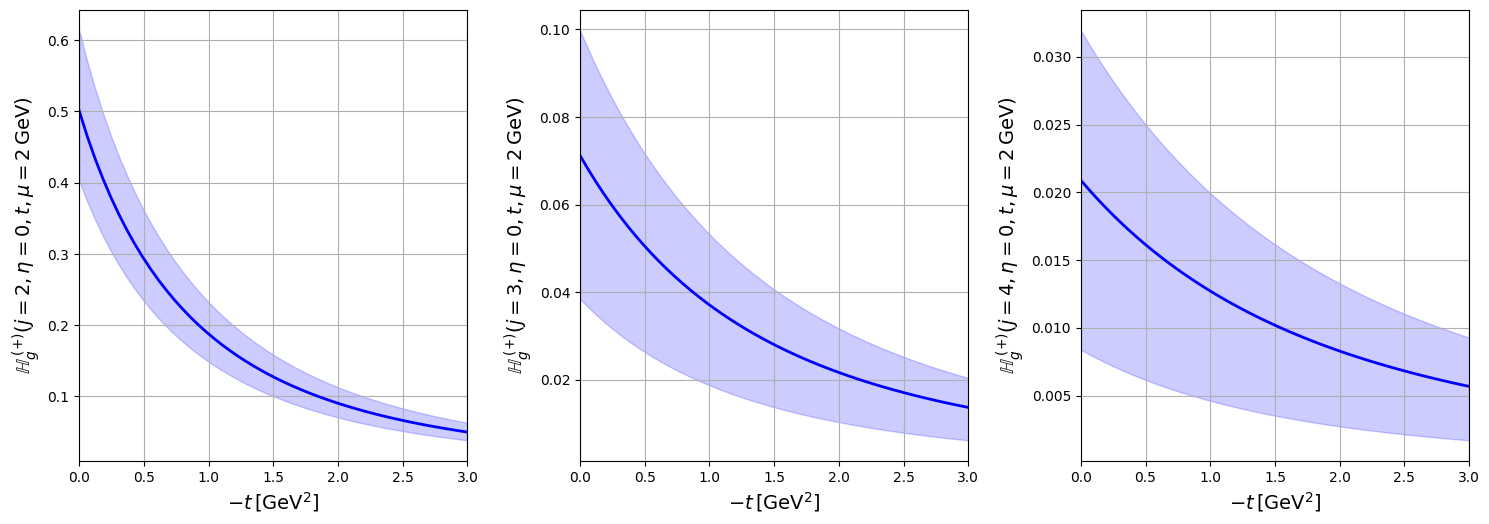

In [14]:
y_label = "$\\mathbb{{H}}_{{g}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(0,y_label,3,3,particle,moment_type,moment_label)

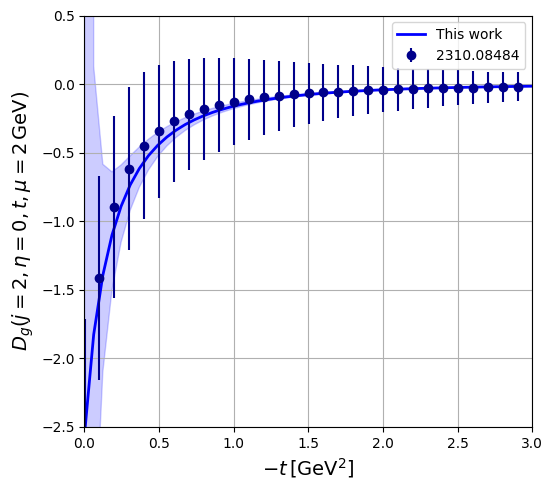

In [2]:
y_label = "$D_{{g}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(0,y_label,3,3,particle,moment_type,moment_label,D_term=True,y_0 = -2.5, y_1=.5,set_y_lim=True)

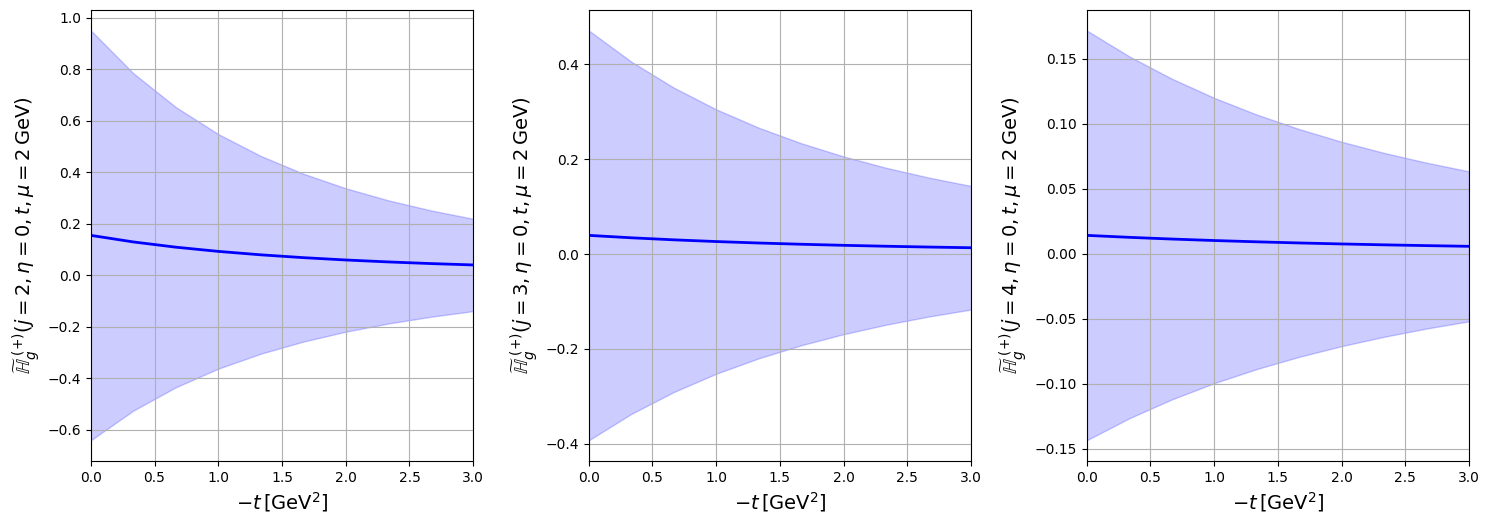

In [15]:
# Gluon singlet
y_label = "$\\widetilde{\\mathbb{{H}}}_{{g}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,3,"gluon",moment_type, moment_label,10)

Plots of GPDs through Mellin-Barnes Integral

Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.024125 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.022588 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.024590 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/non_singlet_isoscalar_quark_GPD_Htilde.pdf


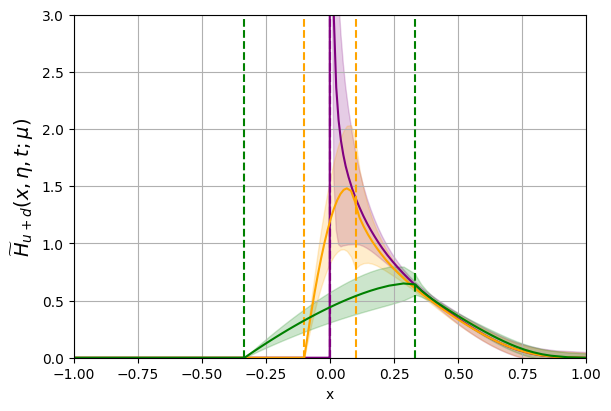

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="non_singlet_isoscalar",gpd_label="Htilde",read_from_file=True, write_to_file=False,y_0=0,y_1=3,plot_legend=False)

Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.036008 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.036237 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.039108 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/non_singlet_isoscalar_quark_GPD_E.pdf


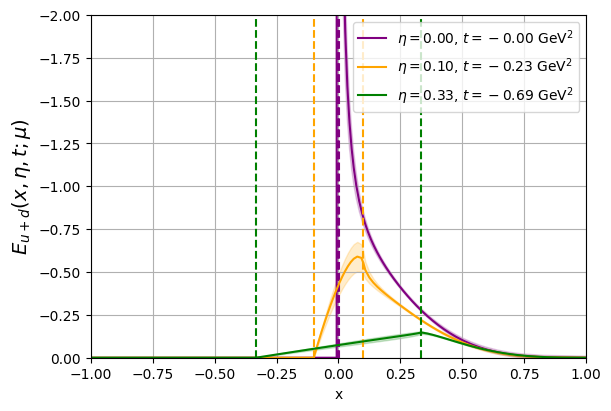

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="non_singlet_isoscalar",gpd_label="E",read_from_file=True, write_to_file=False,y_0=0,y_1=-2,plot_legend=True)

Time for plot computation for parameters (eta,t,mu) = ((0.001, -0.001, 2)): 0.049581 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 0.038945 seconds
Time for plot computation for parameters (eta,t,mu) = ((0.3333333333333333, -0.69, 2)): 0.030953 seconds
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/GPD/NonSingletIsovectorquarkGPD_E.pdf


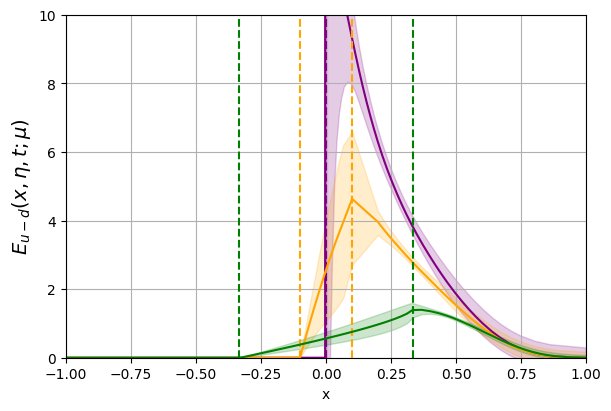

In [ ]:
eta_array = [1e-3,0.1,1/3]
t_array = [-1e-3,-0.23,-0.69]
mu_array = [2,2,2]
colors = ["purple","orange","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="non_singlet_isovector",gpd_label="E",read_from_file=True, write_to_file=False,y_0=0,y_1=10)

/home/hechenvanmountain/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Time for plot computation for parameters (eta,t) = ((0.0, -0.69)): 0.037388 seconds
Time for plot computation for parameters (eta,t) = ((0.33, -0.69)): 0.026723 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 0.027040 seconds


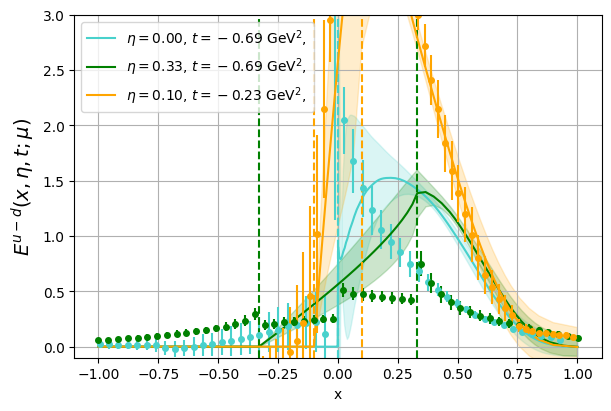

In [ ]:
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="E",read_from_file=True,write_to_file=False,plot_legend=True)

/home/hechenvanmountain/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Time for plot computation for parameters (eta,t) = ((0.0, -0.69)): 0.031749 seconds
Time for plot computation for parameters (eta,t) = ((0.33, -0.69)): 0.033551 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.39)): 0.033198 seconds


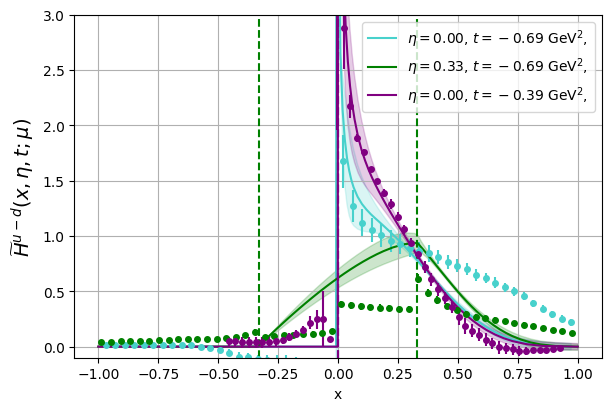

In [ ]:
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="Htilde",read_from_file=True,write_to_file=False,plot_legend=True)